# training_templateのノートブック

In [2]:
!pip install torch==1.6.0
!pip install zarr
!pip install mlflow

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 13.9 MB 4.2 MB/s 
     |████████████████████████████████| 94 kB 8.2 MB/s 
     |████████████████████████████████| 6.0 MB 38.9 MB/s 
     |████████████████████████████████| 145 kB 21.8 MB/s 
     |████████████████████████████████| 40 kB 9.0 MB/s 
     |████████████████████████████████| 1.1 MB 75.7 MB/s 
     |████████████████████████████████| 77 kB 15.8 MB/s 
     |████████████████████████████████| 159 kB 75.6 MB/s 
     |████████████████████████████████| 326 kB 66.4 MB/s 
     |████████████████████████████████| 53 kB 7.1 MB/s 
   

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import os, gc
os.environ["L5KIT_DATA_FOLDER"] = '/home/knikaido/work/Lyft/data/lyft-motion-prediction-autonomous-vehicles'
import zarr
from prettytable import PrettyTable
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from tqdm import tqdm
import time
import cloudpickle
import requests
import mlflow
import yaml
from typing import Dict

import bisect
import itertools as it

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models.resnet import resnet18, resnet50, resnet34
from torch import Tensor
from torch.autograd import Variable
from l5kit.data.filter import filter_agents_by_labels, filter_agents_by_track_id
from l5kit.data import PERCEPTION_LABELS
from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points, compute_agent_pose, rotation33_as_yaw
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
!pip freeze | grep l5kit

l5kit @ file:///home/knikaido/work/Lyft/Git/external/l5kitorigin/l5kit
l5kitcustom @ file:///home/knikaido/work/Lyft/Git/external/l5kitcustom/l5kit


In [3]:
DEBUG = False

common_cfg = {
    'seed': 500,
    'output_dir': './outputs/1021/',
    'epoch': 25,
    'train_step': 5 if DEBUG else 500,
    'valid_step': 5 if DEBUG else 500,
    'train_max': 12,
    'learning_rate': 1e-3
}


# training cfg
training_cfg = {
    
    'format_version': 4,
    
     ## Model options
    'model_params': {
        'model_architecture': 'resnet34',
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1,
    },

    ## Input raster parameters
    'raster_params': {
        
        'raster_size': [224, 224], # raster's spatial resolution [meters per pixel]: the size in the real world one pixel corresponds to.
        'pixel_size': [0.5, 0.5], # From 0 to 1 per axis, [0.5,0.5] would show the ego centered in the image.
        'ego_center': [0.25, 0.5],
        'map_type': "py_semantic",
        
        # the keys are relative to the dataset environment variable
        'satellite_map_key': "aerial_map/aerial_map.png",
        'semantic_map_key': "semantic_map/semantic_map.pb",
        'dataset_meta_key': "meta.json",

        # e.g. 0.0 include every obstacle, 0.5 show those obstacles with >0.5 probability of being
        # one of the classes we care about (cars, bikes, peds, etc.), >=1.0 filter all other agents.
        'filter_agents_threshold': 0.5
    },

    ## Data loader options
    'train_data_loader': {
        'key': "scenes/train.zarr",
        'batch_size': 16,
        'shuffle': True,
        'num_workers': 0
    },

    ## Train params
    'train_params': {
        'checkpoint_every_n_steps': 5000,
        'max_num_steps': 10 if DEBUG else 10000
    }
}


# training cfg
validation_cfg = {
    
    'format_version': 4,
    
     ## Model options
    'model_params': {
        'model_architecture': 'resnet34',
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1,
    },

    ## Input raster parameters
    'raster_params': {
        
        'raster_size': [224, 224], # raster's spatial resolution [meters per pixel]: the size in the real world one pixel corresponds to.
        'pixel_size': [0.5, 0.5], # From 0 to 1 per axis, [0.5,0.5] would show the ego centered in the image.
        'ego_center': [0.25, 0.5],
        'map_type': "py_semantic",
        
        # the keys are relative to the dataset environment variable
        'satellite_map_key': "aerial_map/aerial_map.png",
        'semantic_map_key': "semantic_map/semantic_map.pb",
        'dataset_meta_key': "meta.json",

        # e.g. 0.0 include every obstacle, 0.5 show those obstacles with >0.5 probability of being
        # one of the classes we care about (cars, bikes, peds, etc.), >=1.0 filter all other agents.
        'filter_agents_threshold': 0.5
    },

    ## Data loader options
    'valid_data_loader': {
        'key': "scenes/validate_chopped_100/validate.zarr",
        'batch_size': 16,
        'shuffle': True,
        'num_workers': 0
    },

    ## Valid params
    'valid_params': {
        'checkpoint_every_n_steps': 5000,
        'max_num_steps': 10 if DEBUG else 1000
    }
}

# # inference cfg
# inference_cfg = {
    
#     'format_version': 4,
#     'model_params': {
#         'history_num_frames': 10,
#         'history_step_size': 1,
#         'history_delta_time': 0.1,
#         'future_num_frames': 50,
#         'future_step_size': 1,
#         'future_delta_time': 0.1
#     },
    
#     'raster_params': {
#         'raster_size': [448, 448],
#         'pixel_size': [0.5, 0.5],
#         'ego_center': [0.25, 0.5],
#         'map_type': 'py_semantic',
#         'satellite_map_key': 'aerial_map/aerial_map.png',
#         'semantic_map_key': 'semantic_map/semantic_map.pb',
#         'dataset_meta_key': 'meta.json',
#         'filter_agents_threshold': 0.5
#     },
    
#         'test_data_loader': {
#         'key': 'scenes/test.zarr',
#         'batch_size': 16,
#         'shuffle': False,
#         'num_workers': 0
#     }

# }

In [4]:
OUTPUT_DIR = common_cfg['output_dir']
INPUT_ROOT = Path('/home/knikaido/work/Lyft/data/')
DATA_DIR = INPUT_ROOT / 'lyft-motion-prediction-autonomous-vehicles/'
SAMPLE_ZARR = DATA_DIR / 'scenes/sample.zarr'

# cfg = load_config_data(str(INPUT_ROOT / "lyft-config-files/visualisation_config.yaml"))

In [5]:
def set_seed(seed: int = 42):
#     random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
#     torch.backends.cudnn.deterministic = True  # type: ignore
#     torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(common_cfg['seed'])

In [6]:
# root directory
# DIR_INPUT = "/kaggle/input/lyft-motion-prediction-autonomous-vehicles"

#submission
SINGLE_MODE_SUBMISSION = f"{DATA_DIR}/single_mode_sample_submission.csv"
MULTI_MODE_SUBMISSION = f"{DATA_DIR}/multi_mode_sample_submission.csv"

# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = str(DATA_DIR)
dm = LocalDataManager(None)
print(training_cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet34', 'history_num_frames': 10, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5}, 'train_data_loader': {'key': 'scenes/train.zarr', 'batch_size': 16, 'shuffle': True, 'num_workers': 0}, 'train_params': {'checkpoint_every_n_steps': 5000, 'max_num_steps': 10000}}


In [7]:
PERCEPTION_LABELS = [
    "PERCEPTION_LABEL_NOT_SET",
    "PERCEPTION_LABEL_UNKNOWN",
    "PERCEPTION_LABEL_DONTCARE",
    "PERCEPTION_LABEL_CAR",
    "PERCEPTION_LABEL_VAN",
    "PERCEPTION_LABEL_TRAM",
    "PERCEPTION_LABEL_BUS",
    "PERCEPTION_LABEL_TRUCK",
    "PERCEPTION_LABEL_EMERGENCY_VEHICLE",
    "PERCEPTION_LABEL_OTHER_VEHICLE",
    "PERCEPTION_LABEL_BICYCLE",
    "PERCEPTION_LABEL_MOTORCYCLE",
    "PERCEPTION_LABEL_CYCLIST",
    "PERCEPTION_LABEL_MOTORCYCLIST",
    "PERCEPTION_LABEL_PEDESTRIAN",
    "PERCEPTION_LABEL_ANIMAL",
    "AVRESEARCH_LABEL_DONTCARE",
]
KEPT_PERCEPTION_LABELS = [
    "PERCEPTION_LABEL_UNKNOWN",
    "PERCEPTION_LABEL_CAR",
    "PERCEPTION_LABEL_CYCLIST",
    "PERCEPTION_LABEL_PEDESTRIAN",
]
KEPT_PERCEPTION_LABELS_DICT = {label:PERCEPTION_LABELS.index(label) for label in KEPT_PERCEPTION_LABELS}
KEPT_PERCEPTION_KEYS = sorted(KEPT_PERCEPTION_LABELS_DICT.values())

In [8]:
class LabelEncoder:
    def  __init__(self, max_size=500, default_val=-1):
        self.max_size = max_size
        self.labels = {}
        self.default_val = default_val

    @property
    def nlabels(self):
        return len(self.labels)

    def reset(self):
        self.labels = {}

    def partial_fit(self, keys):
        nlabels = self.nlabels
        available = self.max_size - nlabels

        if available < 1:
            return

        keys = set(keys)
        new_keys = list(keys - set(self.labels))

        if not len(new_keys):
            return
        
        self.labels.update(dict(zip(new_keys, range(nlabels, nlabels + available) )))
    
    def fit(self, keys):
        self.reset()
        self.partial_fit(keys)

    def get(self, key):
        return self.labels.get(key, self.default_val)
    
    def transform(self, keys):
        return np.array(list(map(self.get, keys)))

    def fit_transform(self, keys, partial=True):
        self.partial_fit(keys) if partial else self.fit(keys)
        return self.transform(keys)

In [9]:
class CustomLyftDataset(Dataset):
    feature_mins = np.array([-17.336, -27.137, 0. , 0., 0. , -3.142, -37.833, -65.583],
    dtype="float32")[None,None, None]

    feature_maxs = np.array([17.114, 20.787, 42.854, 42.138,  7.079,  3.142, 29.802, 35.722],
    dtype="float32")[None,None, None]



    def __init__(self, zdataset, scenes=None, nframes=10, frame_stride=15, hbackward=10, 
                 hforward=50, max_agents=150, agent_feature_dim=8):
        """
        Custom Lyft dataset reader.
        
        Parmeters:
        ----------
        zdataset: zarr dataset
            The root dataset, containing scenes, frames and agents
            
        nframes: int
            Number of frames per scene
            
        frame_stride: int
            The stride when reading the **nframes** frames from a scene
            
        hbackward: int
            Number of backward frames from  current frame
            
        hforward: int
            Number forward frames from current frame
        
        max_agents: int 
            Max number of agents to read for each target frame. Note that,
            this also include the backward agents but not the forward ones.
        """
        super().__init__()
        self.zdataset = zdataset
        self.scenes = scenes if scenes is not None else []
        self.nframes = nframes
        self.frame_stride = frame_stride
        self.hbackward = hbackward
        self.hforward = hforward
        self.max_agents = max_agents

        self.nread_frames = (nframes-1)*frame_stride + hbackward + hforward

        self.frame_fields = ['timestamp', 'agent_index_interval', 'ego_translation', 'ego_rotation']

        self.agent_feature_dim = agent_feature_dim

        self.filter_scenes()
      
    def __len__(self):
        return len(self.scenes)

    def filter_scenes(self):
        self.scenes = [scene for scene in self.scenes if self.get_nframes(scene) > self.nread_frames]


    def __getitem__(self, index):
        return self.read_frames(scene=self.scenes[index])

    def get_nframes(self, scene, start=None):
        frame_start = scene["frame_index_interval"][0]
        frame_end = scene["frame_index_interval"][1]
        nframes = (frame_end - frame_start) if start is None else ( frame_end - max(frame_start, start) )
        return nframes


    def _read_frames(self, scene, start=None):
        nframes = self.get_nframes(scene, start=start)
        assert nframes >= self.nread_frames

        frame_start = scene["frame_index_interval"][0]

        start = start or frame_start + np.random.choice(nframes-self.nread_frames)
        frames = self.zdataset.frames.get_basic_selection(
            selection=slice(start, start+self.nread_frames),
            fields=self.frame_fields,
            )
        return frames
    

    def parse_frame(self, frame):
        return frame

    def parse_agent(self, agent):
        return agent

    def read_frames(self, scene, start=None,  white_tracks=None, encoder=False):
        white_tracks = white_tracks or []
        frames = self._read_frames(scene=scene, start=start)
        
        agent_start = frames[0]["agent_index_interval"][0]
        agent_end = frames[-1]["agent_index_interval"][1]

        agents = self.zdataset.agents[agent_start:agent_end]

        X = np.zeros((self.nframes, self.max_agents, self.hbackward, self.agent_feature_dim), dtype=np.float32)
        target = np.zeros((self.nframes, self.max_agents, self.hforward, 2),  dtype=np.float32)
        target_availability = np.zeros((self.nframes, self.max_agents, self.hforward), dtype=np.uint8)
        X_availability = np.zeros((self.nframes, self.max_agents, self.hbackward), dtype=np.uint8)

        for f in range(self.nframes):
            backward_frame_start = f*self.frame_stride
            forward_frame_start = f*self.frame_stride+self.hbackward
            backward_frames = frames[backward_frame_start:backward_frame_start+self.hbackward]
            forward_frames = frames[forward_frame_start:forward_frame_start+self.hforward]
            centroid = backward_frames[0]["ego_translation"][:2]
            yaw = rotation33_as_yaw(backward_frames[0]["ego_rotation"])
            world_from_agent = compute_agent_pose(centroid, yaw)

            backward_agent_start = backward_frames[-1]["agent_index_interval"][0] - agent_start
            backward_agent_end = backward_frames[-1]["agent_index_interval"][1] - agent_start

            backward_agents = agents[backward_agent_start:backward_agent_end]

            le = LabelEncoder(max_size=self.max_agents)
            le.fit(white_tracks)
            le.partial_fit(backward_agents["track_id"])

            for iframe, frame in enumerate(backward_frames):
                backward_agent_start = frame["agent_index_interval"][0] - agent_start
                backward_agent_end = frame["agent_index_interval"][1] - agent_start

                backward_agents = agents[backward_agent_start:backward_agent_end]

                track_ids = le.transform(backward_agents["track_id"])
                mask = (track_ids != le.default_val)
                mask_agents = backward_agents[mask]
                
                mask_ids = track_ids[mask]
                X[f, mask_ids, iframe, :2] = mask_agents["centroid"]
                X[f, mask_ids, iframe, 2:5] = mask_agents["extent"]
                X[f, mask_ids, iframe, 5] = mask_agents["yaw"]
                X[f, mask_ids, iframe, 6:8] = mask_agents["velocity"]

                X_availability[f, mask_ids, iframe] = 1
                
                agent_ego = filter_agents_by_track_id(mask_agents, mask_agents["track_id"])
                
#                 if(iframe == 0):
#                     centroid = frame["ego_translation"][:2]
#                     yaw = rotation33_as_yaw(frame["ego_rotation"])
#                     world_from_agent = compute_agent_pose(centroid, yaw)

            
            for iframe, frame in enumerate(forward_frames):
                forward_agent_start = frame["agent_index_interval"][0] - agent_start
                forward_agent_end = frame["agent_index_interval"][1] - agent_start

                forward_agents = agents[forward_agent_start:forward_agent_end]

                track_ids = le.transform(forward_agents["track_id"])
                mask = track_ids != le.default_val

                target[f, track_ids[mask], iframe] = forward_agents[mask]["centroid"]
                target_availability[f, track_ids[mask], iframe] = 1

        target -= X[:,:,[-1], :2]
        target *= target_availability[:,:,:,None]
        X[:,:,:, :2] -= X[:,:,[-1], :2]
        X *= X_availability[:,:,:,None]
        X -= self.feature_mins
        X /= (self.feature_maxs - self.feature_mins)

        if encoder:
            return X, target, target_availability, le, world_from_agent, centroid
        return X, target, target_availability, world_from_agent, centroid

In [10]:
data_root = DATA_DIR
train_cfg = training_cfg["train_data_loader"]

HBACKWARD = 15
HFORWARD = 0
NFRAMES = 1
FRAME_STRIDE = 0
AGENT_FEATURE_DIM = 8
MAX_AGENTS = 150

In [11]:
class STNkd(nn.Module):
    def __init__(self,  k=64):
        super(STNkd, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv1d(k, 256, kernel_size=1), nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=1), nn.ReLU(),
            nn.Conv1d(256, 512, kernel_size=1), nn.ReLU(),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(512, k*k),nn.ReLU(),
        )
        self.k = k

    def forward(self, x):
        batchsize = x.size()[0]
        x = self.conv(x)
        x = torch.max(x, 2)[0]
        x = self.fc(x)

        iden = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1,
                                                                            self.k*self.k).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

In [12]:
class PointNetfeat(nn.Module):
    def __init__(self, global_feat = False, feature_transform = False, stn1_dim = 120,
                 stn2_dim = 64):
        super(PointNetfeat, self).__init__()
        
        self.global_feat = global_feat
        self.feature_transform = feature_transform
        self.stn1_dim = stn1_dim
        self.stn2_dim = stn2_dim
        
        self.stn = STNkd(k=stn1_dim)
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(stn1_dim, 256, kernel_size=1), nn.ReLU(),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=1), nn.ReLU(),
            nn.Conv1d(256, 1024, kernel_size=1), nn.ReLU(),
            nn.Conv1d(1024, 2048, kernel_size=1), nn.ReLU(),
        )
        
        if self.feature_transform:
            self.fstn = STNkd(k=stn2_dim)

    def forward(self, x):
        n_pts = x.size()[2]
        trans = self.stn(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans)
        x = x.transpose(2, 1)
        
        x = self.conv1(x)

        if self.feature_transform:
            trans_feat = self.fstn(x)
            x = x.transpose(2,1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2,1)
        else:
            trans_feat = None

        pointfeat = x
        
        x = self.conv2(x)
        x = torch.max(x, 2)[0]
        if self.global_feat:
            return x, trans, trans_feat
        else:
            x = x[:,:,None].repeat(1, 1, n_pts)
            return torch.cat([x, pointfeat], 1), trans, trans_feat

In [13]:
class LyftNet(nn.Module):   
    def __init__(self):
        super().__init__()
        
        self.pnet = PointNetfeat()

        self.fc0 = nn.Sequential(
            nn.Linear(2048+256, 1024), nn.ReLU(),
        )

        self.fc = nn.Sequential(
            nn.Linear(1024, 300),
        )

        self.c_net = nn.Sequential(
            nn.Linear(1024, 3),
        )
        
    
    def forward(self, x):
        bsize, npoints, hb, nf = x.shape 
        
        # Push points to the last  dim
        x = x.transpose(1, 3)

        # Merge time with features
        x = x.reshape(bsize, hb*nf, npoints)

        x, trans, trans_feat = self.pnet(x)

        # Push featuresxtime to the last dim
        x = x.transpose(1,2)

        x = self.fc0(x)

        c = self.c_net(x)
        x = self.fc(x)

        return c,x

In [14]:
# mask = np.load(DATA_ROOT/"scenes/mask.npz")['arr_0']
mask = np.load(f"{str(DATA_DIR)}/scenes/validate_chopped_100/mask.npz")["arr_0"]
agent_ids = np.where(mask)[0]
agent_ids

array([     7381,      7385,      7436, ..., 125414981, 125423173,
       125423178])

In [15]:
data_root = DATA_DIR
valid_cfg = validation_cfg["valid_data_loader"]

In [16]:
z = zarr.open(data_root.joinpath(valid_cfg["key"]).as_posix(), "r")
frames_ij = z.scenes["frame_index_interval"]
agents_ij = z.frames["agent_index_interval"]
# ego_translation_ij = z.frames["ego_translation"]

In [17]:
def get_scene(agent_id):
    frame_id = bisect.bisect_right(agents_ij[:, 0], agent_id)-1
    scene_id = bisect.bisect_right(frames_ij[:, 0], frame_id)-1
#     ego_translation_id =  bisect.bisect_right(ego_translation_ij[:, 0], frame_id)-1
    
    scene = z.scenes[scene_id]
    frame = z.frames[frame_id]
    agent = z.agents[agent_id]
#     ego_translation = z.frames[ego_translation_id]
    return scene,(frame,frame_id),agent

In [18]:
agent_id = agent_ids[np.random.choice(len(agent_ids))]
scene,(frame,frame_id), agent = get_scene(agent_id)
scene,(frame,frame_id), agent["track_id"]

(([1107100, 1107200], 'host-a117', 1580165480985567232, 1580165505985567232),
 ((1580165491102386186, [85981124, 85981205], [8160654, 8160663], [-802.69750977, 1183.20654297,  271.54284668], [[ 0.67490309,  0.73712373, -0.03397717], [-0.73775208,  0.67310476, -0.05149622], [-0.01508889,  0.05982168,  0.99809504]]),
  1107199),
 638)

In [19]:
dt = CustomLyftDataset(
        z, 
        nframes=NFRAMES,
        frame_stride=FRAME_STRIDE,
        hbackward=HBACKWARD,
        hforward=HFORWARD,
        max_agents=MAX_AGENTS,
        agent_feature_dim=AGENT_FEATURE_DIM,
)
dt.nread_frames

15

In [20]:
paths = [
    "../input/neural-net-on-lyft-tabular-data/lyfnet_epoch13.ckpt",
]
weights = np.array([1.0])
weights /= weights.sum()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nets = []

net = LyftNet().to(device)
net.load_state_dict(torch.load('./outputs/1019/model'))
#     net.load_state_dict(torch.load(path, map_location=DEVICE)["state_dict"])
net.eval()
nets.append(net)

nets[0]

LyftNet(
  (pnet): PointNetfeat(
    (stn): STNkd(
      (conv): Sequential(
        (0): Conv1d(120, 256, kernel_size=(1,), stride=(1,))
        (1): ReLU()
        (2): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
        (3): ReLU()
        (4): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
        (5): ReLU()
      )
      (fc): Sequential(
        (0): Linear(in_features=512, out_features=14400, bias=True)
        (1): ReLU()
      )
    )
    (conv1): Sequential(
      (0): Conv1d(120, 256, kernel_size=(1,), stride=(1,))
      (1): ReLU()
    )
    (conv2): Sequential(
      (0): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (1): ReLU()
      (2): Conv1d(256, 1024, kernel_size=(1,), stride=(1,))
      (3): ReLU()
      (4): Conv1d(1024, 2048, kernel_size=(1,), stride=(1,))
      (5): ReLU()
    )
  )
  (fc0): Sequential(
    (0): Linear(in_features=2304, out_features=1024, bias=True)
    (1): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=1024, out_featur

In [21]:
def make_colnames():
    cols1= list(
        it.chain(*[
    [f"coord_x0{i}", f"coord_y0{i}"]
    for i in range(50)]))
    cols2= list(
        it.chain(*[
    [f"coord_x1{i}", f"coord_y1{i}"]
    for i in range(50)]))
    cols3= list(
        it.chain(*[
    [f"coord_x2{i}", f"coord_y2{i}"]
    for i in range(50)]))
    cols = cols1 + cols2 + cols3
    return ["timestamp", "track_id"] + ["conf_0", "conf_1", "conf_2"] + cols

# def make_colnames():
#     cols= list(
#         it.chain(*[
#     [f"coord_x0{i}", f"coord_y0{i}", f"coord_x1{i}", f"coord_y1{i}", f"coord_x2{i}", f"coord_y2{i}"]
#     for i in range(50)]))
#     return ["timestamp", "track_id"] + ["conf_0", "conf_1", "conf_2"] + cols

In [22]:
for icount, agent_id in tqdm(list(enumerate(agent_ids))):
    
    scene, (frame,frame_id), agent = get_scene(agent_id)
    c = np.zeros(3)
    y = np.zeros(300)
#     try:
    X, target,_, le, world_from_agents, centroids  = dt.read_frames(scene,
        start=frame_id-HBACKWARD+1,
        white_tracks=[agent["track_id"]],
        encoder=True
    )

    X = torch.from_numpy(X).to(device)
    cs,ys=  [],[]
    for net in nets:
        c, y = net(X)
        c = torch.softmax(c[0, [le.labels[agent["track_id"]]]],dim=1)[0].cpu().detach().numpy()
        y = y[0, le.labels[agent["track_id"]]].cpu().detach().numpy()
        y = y.reshape(-1, 2)
        y = np.vstack([y[::3], y[1::3], y[2::3]])
        y = y.reshape(300)
        y = y.reshape(1, 3, 50, 2)
        centroids = centroids.reshape(1, 2)
        world_from_agents = world_from_agents.reshape(1, 3, 3)
#         print(y.shape, world_from_agents.shape, centroids.shape)
        for y, world_from_agent, centroid in zip(y, world_from_agents, centroids):
            for i in range(3):
                print(y[i, :, :].shape, world_from_agent.shape, centroid.shape)
                y[i, :, :] = transform_points(y[i, :, :], world_from_agent) - centroid[:2]
        y = y.reshape(300)
    
    break

  0%|          | 0/94694 [00:00<?, ?it/s]

(50, 2) (3, 3) (2,)
(50, 2) (3, 3) (2,)
(50, 2) (3, 3) (2,)


In [23]:
centroids

array([[  538.96112061, -2397.18334961]])

In [24]:
x1 = y[::2][:50]
y1 = y[1::2][:50]
y1.shape

(50,)

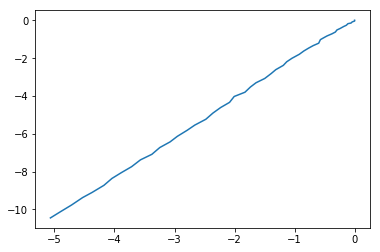

In [25]:
plt.plot(x1, y1)

In [26]:
@torch.no_grad()
def predict(agent_id):
    scene, (frame,frame_id), agent = get_scene(agent_id)
    c = np.zeros(3)
    y = np.zeros(300)
#     try:
    X, _,_, le, world_from_agents, centroids  = dt.read_frames(scene,
        start=frame_id-HBACKWARD+1,
        white_tracks=[agent["track_id"]],
        encoder=True
    )

    X = torch.from_numpy(X).to(device)
    cs,ys=  [],[]
    for net in nets:
        c, y = net(X)
        c = torch.softmax(c[0, [le.labels[agent["track_id"]]]],dim=1)[0].cpu().detach().numpy()
        y = y[0, le.labels[agent["track_id"]]].cpu().detach().numpy()
        y = y.reshape(-1, 2)
        y = np.vstack([y[::3], y[1::3], y[2::3]])
        y = y.reshape(300)
#         y = y.reshape(1, 3, 50, 2)
#         centroids = centroids.reshape(1, 2)
#         world_from_agents = world_from_agents.reshape(1, 3, 3)
# #         print(y.shape, world_from_agents.shape, centroids.shape)
#         for y, world_from_agent, centroid in zip(y, world_from_agents, centroids):
#             for i in range(3):
# #                 print(y[i, :, :].shape, world_from_agent.shape, centroid.shape)
#                 y[i, :, :] = transform_points(y[i, :, :], world_from_agent) - centroid[:2]
#         y = y.reshape(300)

        cs.append(c)
        ys.append(y)

    cs = np.sum(np.vstack(cs)*weights[None], axis=1)
    ys = np.vstack(ys).reshape(len(ys), 50, 3, 2)
    ys = np.sum(ys*weights[None,None,:,None], axis=2).reshape(len(ys), -1)
        
#     except Exception as e:
#         print(f'Exception : {e}')
#         raise ValueError() from e
    return [frame["timestamp"]],[agent["track_id"]],c,y

In [27]:
%%time

timestamp,track_id, c,y = [],[],[],[]

for icount, agent_id in tqdm(list(enumerate(agent_ids))):
    _timestamp, _track_id, _c,_y = predict(agent_id)
    timestamp.extend(_timestamp)
    track_id.extend(_track_id)
    c.append(_c)
    y.append(_y)
    
#     break
c = np.vstack(c)
y = np.vstack(y)
y.shape, c.shape

100%|██████████| 94694/94694 [21:47<00:00, 72.43it/s]


CPU times: user 14min 23s, sys: 3min, total: 17min 24s
Wall time: 21min 47s


((94694, 300), (94694, 3))

In [28]:
cols = make_colnames()
df = pd.DataFrame(columns=cols)
df[cols[0]] = timestamp
df[cols[1]] = track_id
df[cols[2:5]] = c
df[cols[5:]] = y
df.shape

(94694, 305)

In [29]:
pred_path = f"{OUTPUT_DIR}/pred_1019_trans.csv"

In [30]:
df.to_csv(pred_path, index=False)

In [31]:
# data_path = "./outputs/1011_2/pred_1010.csv"
# df_ = pd.read_csv(data_path)
# df_
# one = df_.loc[0, 'coord_x00':'coord_y049']

In [32]:
eval_gt_path = str(f"{str(DATA_DIR)}/scenes/validate_chopped_100/gt.csv")

In [33]:
metrics = compute_metrics_csv(eval_gt_path, pred_path, [neg_multi_log_likelihood, time_displace])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)

neg_multi_log_likelihood 68.99323391023742
time_displace [0.04240233 0.06962155 0.09542116 0.12034258 0.14416635 0.16798403
 0.19202536 0.21629761 0.24051419 0.26494686 0.29156362 0.31952253
 0.34778033 0.37554267 0.40375837 0.43183687 0.45984296 0.48804172
 0.51549584 0.54422048 0.57157881 0.59989759 0.62770612 0.65511102
 0.68377525 0.7111695  0.73863428 0.76729367 0.79547409 0.82313819
 0.85208252 0.88134809 0.91043392 0.93863322 0.96906848 0.99926524
 1.02957427 1.06199304 1.09230192 1.12315929 1.15457542 1.18749408
 1.22122223 1.25552258 1.29159702 1.32675269 1.36093795 1.39760403
 1.43608798 1.47376959]


In [39]:
def order(out_pos, confi):
    confi = np.argsort(confi)[::-1]
    out_list = []
    for i in confi:
        out_list.append(out_pos[i*50:i*50+50, :])
    return np.array(out_list)

In [ ]:
model.eval()
torch.set_grad_enabled(False)
plt.rcParams['figure.figsize'] = 8, 8
# build a dict to retrieve future trajectories from GT
gt_rows = {}
for row in read_gt_csv(eval_gt_path):
    gt_rows[row["track_id"] + row["timestamp"]] = row["coord"]

eval_ego_dataset = EgoDataset(cfg, eval_dataset.dataset, rasterizer)

for frame_number in range(99, len(eval_zarr.frames), 100):  # start from last frame of scene_0 and increase by 100
    agent_indices = eval_dataset.get_frame_indices(frame_number) 
    if not len(agent_indices):
        continue

    # get AV point-of-view frame
    data_ego = eval_ego_dataset[frame_number]
    im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
    center = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    
    predicted_positions1 = []
    predicted_positions2 = []
    predicted_positions3 = []
    target_positions = []

    for v_index in agent_indices:
        data_agent = eval_dataset[v_index]

        out_net, confi = model(torch.from_numpy(data_agent["image"]).unsqueeze(0).to(device))
        out_pos = out_net[0].reshape(-1, 2).detach().cpu().numpy()
        confi = confi[0].detach().cpu().numpy()
        # store absolute world coordinates
        out_pos = order(out_pos, confi)
        predicted_positions1.append(transform_points(out_pos[0], data_agent["world_from_agent"]))
        predicted_positions2.append(transform_points(out_pos[1], data_agent["world_from_agent"]))
        predicted_positions3.append(transform_points(out_pos[2], data_agent["world_from_agent"]))
        # retrieve target positions from the GT and store as absolute coordinates
        track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
        target_positions.append(gt_rows[str(track_id) + str(timestamp)] + data_agent["centroid"][:2])



    # convert coordinates to AV point-of-view so we can draw them
    predicted_positions1 = transform_points(np.concatenate(predicted_positions1), data_ego["raster_from_world"])
    predicted_positions2 = transform_points(np.concatenate(predicted_positions2), data_ego["raster_from_world"])
    predicted_positions3 = transform_points(np.concatenate(predicted_positions3), data_ego["raster_from_world"])
    target_positions = transform_points(np.concatenate(target_positions), data_ego["raster_from_world"])

    draw_trajectory(im_ego, predicted_positions1, (0, 255, 255))
    draw_trajectory(im_ego, predicted_positions2, (0, 200, 200))
    draw_trajectory(im_ego, predicted_positions3, (0, 128, 128))
    draw_trajectory(im_ego, target_positions, (255, 0, 255))

    plt.imshow(im_ego[::-1])
    plt.show()
    
#     break